#### Exam project on
# Audio Features for Music Genre Classification
### 02452 - Audio Information Processing Systems

#### Nicklas Hansen (s153077) & Bragi Marinosson (s185510)

#### About

This notebook contains code and results for the exam project on Music Genre Classification for the 02452 graduate course offered at the Technical University of Denmark (DTU). Unless authorship of code and documentation is stated explicitly (e.g. in the function description), it can be assumed implemented by Nicklas Hansen.

The work presented in this notebook is to be considered open source under the MIT License. If you found this code useful in your research, then please cite


```
@inproceedings{mgc-hansen-marinosson,
  title={Audio Features for Music Genre Classification},
  author={Hansen, Nicklas and Marinosson, Bragi},
  year={2019}
}
```

#### Data

Raw, high-quality MP3-encoded audio data (30 s per sample) and genre classifications from the Free Music Archive (FMA) dataset is used in this study. For more information on the dataset, visit https://github.com/mdeff/fma/ and/or read the paper *FMA: A Dataset For Music Analysis*, Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson (2017).

As the original dataset contains 105 GB of audio data, we do not make that data available directly. To get your hands on the raw data, refer to the aforementioned website and paper. The original dataset is required in order to run the preprocessing steps in this code. Optionally, you can skip this step by setting the ``PREPROCESS`` global parameter to ``False`` and instead downloading our preprocessed data, which only takes up roughly 3 GB and saves you a lot of time. At courtesy of the author (Nicklas Hansen), preprocessed data is made available at the following link:

https://1drv.ms/f/s!AnqePMbr4kj8psYKNe0WElp5YDE01g

Please note that we cannot guarantee the availability of this data indefinitely. Therefore, you may have to rerun the preprocessing step yourself in the future.

#### Setup

All code was developed and tested on Windows 10 (version 10.0.17134) with Python 3.7 and has been verified to work both with and without a GPU, although it is highly recommended to use one during training of neural networks as it decreases wall time significantly. For this study, a GTX1080 unit was used on a computer with 16 GB RAM, but less should be sufficient.

#### Imports

Required dependencies are listed as imports below. If you intend to run this code on your own machine, please make sure that you have installed all of the below dependencies before proceeding.

In [1]:
import os
import sys
import numpy as np
import h5py
import pickle
import collections
from collections import defaultdict
from random import shuffle
import matplotlib.pyplot as plt
from sklearn import model_selection, neighbors, metrics, preprocessing
from sklearn.utils import shuffle
import time
from IPython.display import clear_output
import librosa
from librosa import display
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import Linear, RNN, LSTM
import torch.nn.functional as F
from torch.nn.functional import softmax, relu
from torch.autograd import Variable
import torch.optim as optim

C:\Users\nickl\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Working directory as data path

You need to set this path to the root of the dataset, keeping all folders as is, but removing files in the root directory that are not MP3 files as the code does not check for this (resulting in less operations).

In [2]:
os.chdir('C:/FMA/')

#### Path to additional files

You need to set this path to a location that either contains files related to this code or a location in which you want to store such files.

In [3]:
GENRES = 'C:/Users/nickl/OneDrive/DTU_2019/Audio Information Processing Systems/Music Genre Classification/'

#### Set global seed for reproducibility

In [4]:
def set_seed(seed = int(0x02452)):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed = seed
    
set_seed()

#### Global parameters

``PREPROCESS`` determines whether the code should redo the preprocessing step or not. If you already preprocessed the original data or downloaded our preprocessed files, you can set ``PREPROCESS`` to ``False`` for a significant speed-up. Otherwise, you will have to complete the preprocessing step.

``NUM_CLASSES`` determines the number of genres to be used for classification. In this study we use 7 classes, but in principle this could be any number of classes (up to the number of genres in the dataset). Aside from the discarded classes as noted in the ``load_tracklist`` function, the classes used are selected based on the number of available samples (favoring a high count). A hard limit of 1000 audio files per genre has been set to decrease class imbalance.

``NUM_FRAMES`` determines the number of frames used in each audio segment. Due to a window size of 2048 and a hop length of 1024, we require 128 frames to represent 3 seconds of audio as used in our study.

``MFCC_COEFFICIENTS`` determines the number of MFCC coefficients (frequency bands) to be used to model the Mel-frequency spectrum of the audio signal. A high number of coefficents produces a good frequency resolution but also requires proportionally more space and computation.

In [5]:
PREPROCESS = False
RERUN_BASELINES = True

NUM_CLASSES = 7
NUM_FRAMES = 128
MFCC_COEFFICIENTS = 32

np.set_printoptions(precision=2)

#### Get all available files

In [6]:
def load_data(target_file='train'):
    '''
    Loads any data from target location.
    '''
    with open(GENRES + target_file + '.pickle', 'rb') as handle:
        return pickle.load(handle)
    
    
def save_data(data, target_file='train'):
    '''
    Saves any data to target location.
    '''
    with open(GENRES + target_file + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

def load_tracklist(discarded_genres=['Experimental', 'International', 'Instrumental', 'Old-Time / Historic', 'Spoken']):
    '''
    Load list of tracks with genre information as data frame.
    '''
    tracklist = pd.read_csv(GENRES + 'genres.csv').set_index('id', drop=True)
    
    tracklist = tracklist[tracklist.genre.notnull()]
    for genre in discarded_genres:
        tracklist = tracklist[tracklist.genre != genre]

    return tracklist


def get_file_list(verbose=False):
    '''
    Returns a list of all .h5 files in current working directory.
    '''
    files = []
    for r, d, f in os.walk(os.getcwd()):
        for file in f:
            if '.mp3' in file:
                files.append(os.path.join(r, file))

    print(f'Found {len(files)} files!')
    return files


def train_test_split(files, test_num=None, p=None):
    '''
    Returns two lists (train and test). If test_num is
    not None, the second list will contain test_num number
    of elements and the first list contains the remainder.
    If p is not None, lists are populated such that the first
    list contains elements selected with p probability
    and the second list contains elements selected with
    1-p probability (at random).
    '''
    if test_num is not None:
        return files[:-test_num], files[-test_num:]
    
    elif p is not None:
        lsts = [], []
        for file in files:
            a = np.random.choice(2, 1, p=[p, 1-p])[0]
            lsts[a].append(file)
        return lsts
    
    raise ParameterError('Either test_num or p must have a value!')

    
def id_from_filename(file):
    return str(int(file.split('\\')[-1].split('.')[0]))
    

def get_top_genres(genre_dict):
    '''
    Returns the top occurring genres as a list.
    '''
    lst = sorted(genre_dict, key=genre_dict.get, reverse=True)
    return lst[:NUM_CLASSES] if len(lst) > NUM_CLASSES else lst
    
    
def files_with_available_genre(files, predefined_tracklist=None, genre_cap=None, return_genre_count=False, verbose=False):
    
    lst, genres, tracklist = [], defaultdict(int), load_tracklist()

    for file in files:
        idx = id_from_filename(file)
        
        try:
            g = tracklist.loc[idx].genre
            
            if genre_cap is not None and genres[g] >= 1000:
                continue
                
            if (predefined_tracklist is None or g in predefined_tracklist):
                lst.append(file)
                genres[g] += 1
        except:
            continue
    
    if predefined_tracklist is None:
        print(f'Found {len(lst)} files with labels!')
    else:
        print(f'Found {len(lst)} files with labels among top {NUM_CLASSES} genres!')
    
    if return_genre_count is True:
        return lst, get_top_genres(genres), genres
    
    return lst, get_top_genres(genres)


if PREPROCESS is True:
    files, genres = files_with_available_genre(get_file_list(verbose=True), verbose=True)
    files, genres, genre_count = files_with_available_genre(shuffle(files), genres, genre_cap=1000, return_genre_count=True, verbose=True)
    
    train_files, test_files = train_test_split(files, p=0.9)
    class_weights = np.array([1/(genre_count[g]/(len(files)/NUM_CLASSES)) for g in genres])

    save_data((genres, class_weights), 'class_weights')
    
    print('\nTrain files:', len(train_files), '\nTest  files:', len(test_files), '\n\nClasses and class weights:')
    print(genres)
    print(class_weights)

#### Extract features

In [7]:
def mfcc_from_audio(x, sr, n_mfcc=MFCC_COEFFICIENTS):
    '''
    Computes MFCCs of an audio file.
    '''
    return librosa.feature.mfcc(x, sr, n_mfcc=n_mfcc, n_fft=2048, hop_length=1024)


def chromas_from_audio(x, sr):
    '''
    Computes chroma features of an audio file.
    @author: Bragi Marinosson
    '''
    return librosa.feature.chroma_stft(y=x, sr=sr, n_fft=2048, hop_length=1024)


def tempo_from_audio(x, sr):
    '''
    Computes the tempo (bpm) for each segment of an audio file.
    @author: Bragi Marinosson
    '''
    tempo = np.zeros((10,))
    shft = 3*sr
    for i in range(10):
        if (i+1)*shft>x.shape[0]:
            onset_env = librosa.onset.onset_strength(x[i*shft:], sr=sr)
            tempo[i] = librosa.beat.tempo(x[i*shft:], sr=sr)
        else:
            onset_env = librosa.onset.onset_strength(x[i*shft:(i+1)*shft], sr=sr)
            tempo[i] = librosa.beat.tempo(x[i*shft:(i+1)*shft], sr=sr)
    
    return tempo


def crest_factor_from_audio(x, sr):
    '''
    Computes the crest factor for each segment of an audio file.
    @author: Bragi Marinosson
    '''
    C = np.zeros((10,))
    shft = 3*sr
    for i in range(10):
        if (i+1)*shft>x.shape[0]:
            C[i] = np.max(abs(x[i*shft:]))/np.sqrt(np.mean(x[i*shft:]**2))
        else:
            C[i] = np.max(abs(x[i*shft:(i+1)*shft]))/np.sqrt(np.mean(x[i*shft:(i+1)*shft]**2))
    C = 20*np.log10(C)
    return [1 if math.isnan(c) else c for c in C] 


def audio_duration_from_file(file, tracklist=load_tracklist()):
    '''
    Extracts the audio duration from an audio file.
    '''
    rec = tracklist.loc[id_from_filename(file)]
    return int(rec.duration)


def generate_data(files, genres, target_file='train', skip_factor=1):
    '''
    Generates features and labels from from a sequence
    of filenames and stores the resulting data as a
    pickle object on the specified path.
    '''
    tracklist = load_tracklist()
    X, y = [], []
    
    for file_num, file in enumerate(files):
        try:
            x, sr = librosa.load(file, sr=None)
            mfccs = np.transpose(mfcc_from_audio(x, sr))
            chromas = np.transpose(chromas_from_audio(x, sr))
            tempo = tempo_from_audio(x, sr)
            crest = crest_factor_from_audio(x, sr)
            dur = audio_duration_from_file(file, tracklist)

            idx, lbl, idx_t = 0, tracklist.loc[id_from_filename(file)].genre, 0
            while idx < mfccs.shape[0] - NUM_FRAMES:
                X.append([mfccs[idx:idx+NUM_FRAMES], chromas[idx:idx+NUM_FRAMES], tempo[idx_t], crest[idx_t], dur])
                y.append(genres.index(lbl))
                idx += NUM_FRAMES*skip_factor
                idx_t += 1
            idx, lbl = 0, tracklist.loc[id_from_filename(file)].genre
        except KeyboardInterrupt:
            raise
        except:
            continue

        sys.stdout.write(f'\rGenerating {target_file} data: {int((file_num+1)*100/len(files))}% ({file_num+1})')
        sys.stdout.flush()
    
    save_data((X,y), target_file)
    
    
if PREPROCESS is True:
    generate_data(train_files, genres, target_file='train')
    generate_data(test_files, genres, target_file='test')

#### Load data from file

In [8]:
X_train, y_train = load_data('train')
X_train, y_train = shuffle(X_train, y_train)
print(f'Loaded {len(y_train)} sequences from train file.')

X_test, y_test = load_data('test')
print(f'Loaded {len(y_test)} sequences from test file.')

genres, class_weights = load_data('class_weights')
print(f'Loaded {len(genres)} classes and weights.')

Loaded 57271 sequences from train file.
Loaded 6260 sequences from test file.
Loaded 7 classes and weights.


#### Plot MFCC and chromas of a single sample

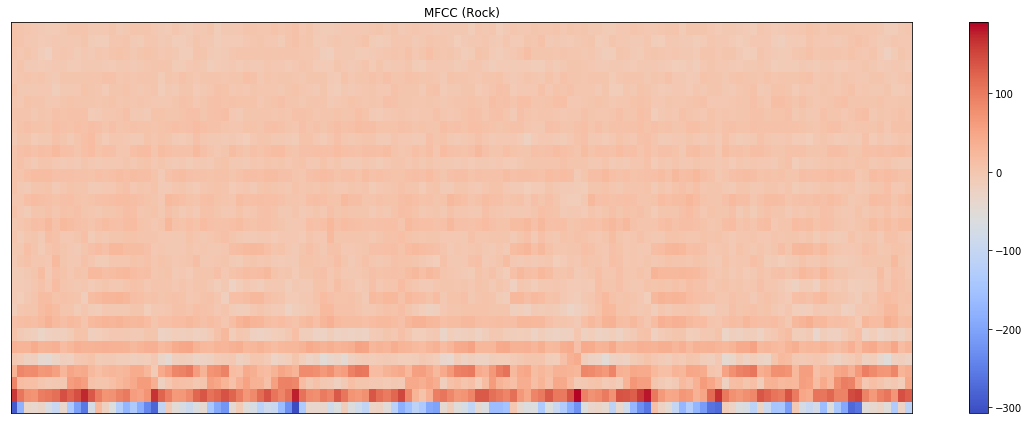

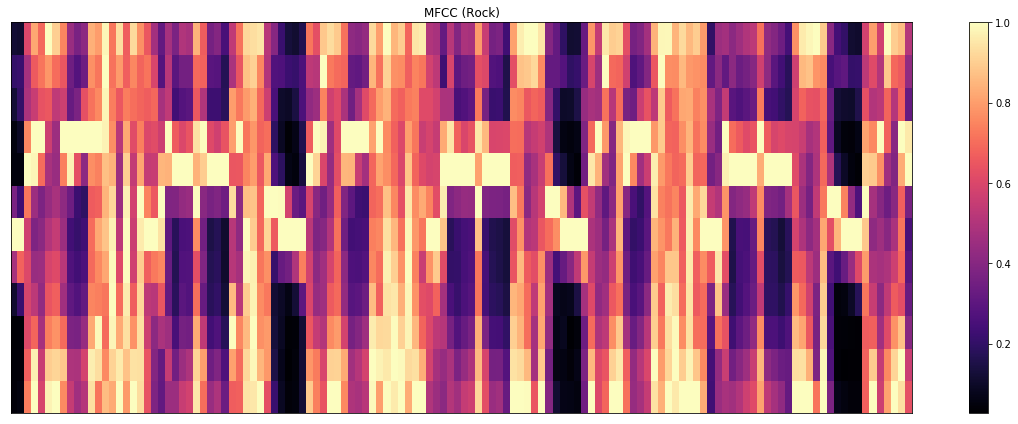

In [10]:
def plot(x, y, title='MFCC'):
    plt.figure(figsize=(16, 6))
    librosa.display.specshow(np.transpose(x))
    plt.colorbar()
    plt.title(f'{title} ({y})')
    plt.tight_layout()
    plt.show()
    
plot(X_train[0][0], genres[y_test[0]])
plot(X_train[0][1], genres[y_test[0]])

## Baseline Random Prediction

In order to evaluate a model's performance, we need to consider a random classification baseline where we take the class distribution into account (as our dataset is imbalanced). The distribution can be inferred by the class weights that we computed during preprocessing.

#### Performance metrics

In [10]:
def compute_metrics(y_true, y_pred):
    print('Accuracy:', str(int(metrics.accuracy_score(y_true, y_pred)*100)) + '%\n')
    print(metrics.classification_report(y_true, y_pred))
    metrics.confusion_matrix(y_true, y_pred)
    
    
def compute_confusion_matrix(y_true, y_pred, classes=genres, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Normalized confusion matrix'
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    fig.tight_layout()
    plt.show()

#### Baseline performance

Accuracy: 14%

              precision    recall  f1-score   support

           0       0.16      0.14      0.15      1065
           1       0.13      0.15      0.14       800
           2       0.18      0.17      0.18       985
           3       0.15      0.14      0.15      1070
           4       0.13      0.15      0.14       810
           5       0.17      0.17      0.17       970
           6       0.09      0.09      0.09       560

    accuracy                           0.15      6260
   macro avg       0.14      0.14      0.14      6260
weighted avg       0.15      0.15      0.15      6260



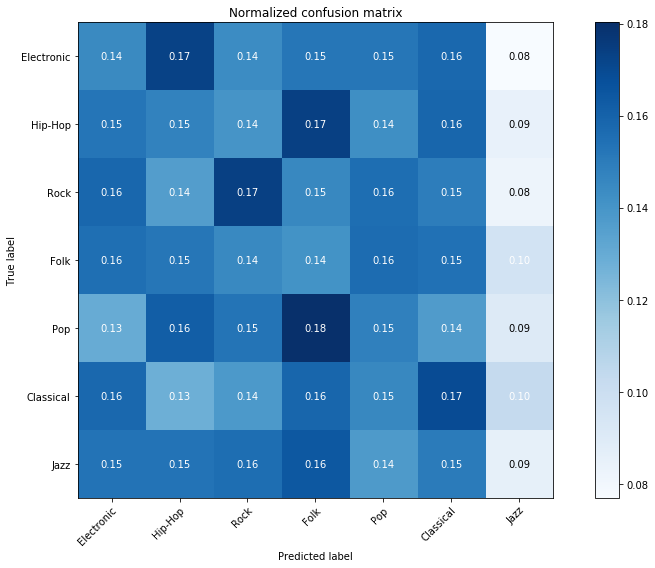

In [11]:
if RERUN_BASELINES:
    class_prob = (1/class_weights)/(sum(1/class_weights))
    y_brp = np.random.choice(NUM_CLASSES, len(y_test), p=class_prob)

    compute_metrics(y_test, y_brp)
    compute_confusion_matrix(y_test, y_brp)

As expected, the random baseline achieves a better-than-random f1-score for the classes that are overrepresented and likewise a poorer performance on the underrepresented classes.

## Baseline Prediction by Audio Duration

Before doing anything remotely advanced, it's relevant to evaluate how well song duration correlates with music genre. To test this, we set up a small experiment where we train a traditional KNN classifier to predict music genre based on standardized audio duration alone.

#### Normalize, predict and evaluate

Accuracy: 17%

              precision    recall  f1-score   support

           0       0.22      0.35      0.27      1065
           1       0.13      0.19      0.15       800
           2       0.19      0.22      0.20       985
           3       0.16      0.12      0.14      1070
           4       0.09      0.05      0.06       810
           5       0.30      0.19      0.23       970
           6       0.08      0.04      0.05       560

    accuracy                           0.18      6260
   macro avg       0.16      0.17      0.16      6260
weighted avg       0.17      0.18      0.17      6260



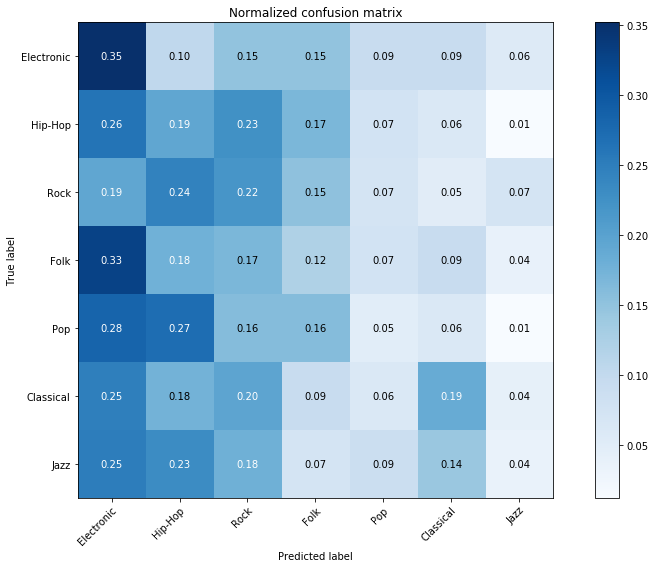

In [12]:
if RERUN_BASELINES:
    _, __, ___, ____, X_dur_train = map(list, zip(*X_train))
    _, __, ___, ____, X_dur_test = map(list, zip(*X_test))
    
    X_dur_train = np.array(X_dur_train).reshape(-1, 1)
    X_dur_test = np.array(X_dur_test).reshape(-1, 1)
    
    y_dur_train = np.copy(y_train)
    y_dur_test = np.copy(y_test)
    
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_dur_train)

    knn = neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(scaler.transform(X_dur_train), y_dur_train)
    y_pred = knn.predict(scaler.transform(X_dur_test))

    compute_metrics(y_dur_test, y_pred)
    compute_confusion_matrix(y_dur_test, y_pred)

Perhaps surprisingly, audio duration does not appear to be a good indicator of genre in most cases. Apart from Electronic, Hip-Hop and Classical, performance actually *decreases* compared to random guessing. Let's take a look at the summary statistics for audio duration:

In [13]:
_, __, ___, ____, X_dur_train = map(list, zip(*X_train))
_, __, ___, ____, X_dur_test = map(list, zip(*X_test))

X_dur_train = np.array(X_dur_train).reshape(-1, 1)
X_dur_test = np.array(X_dur_test).reshape(-1, 1)

y_dur_train = np.copy(y_train)
y_dur_test = np.copy(y_test)


def audio_duration_mean_std(genre=0):
    '''
    Computes the mean and standard deviation
    of audio durations for a given genre.
    '''
    samples = zip(X_dur_train, y_train)
    samples_filtered = []

    for sample in samples:
        if sample[1] == genre:
            samples_filtered.append(sample[0])
    
    return np.mean(samples_filtered), np.std(samples_filtered)


for genre in range(NUM_CLASSES):
    print(f'{genres[genre]}:', audio_duration_mean_std(genre))

Electronic: (259.31064952949276, 165.51459044503093)
Hip-Hop: (206.4337748344371, 102.3505485937931)
Rock: (229.34715666441897, 170.64418579933763)
Folk: (228.40323492817555, 152.8001243712156)
Pop: (215.03730957913763, 144.83663893323515)
Classical: (318.05230596175477, 409.99313318040765)
Jazz: (383.3748535728231, 331.8309400883381)


## K-Nearest Neighbors

We will be using the traditional KNN classifier as a performance baseline. Because prediction time scales linearly with the number of dimensions, it is necessary to transform the features to a smaller dimensional space before feeding it into the classifier. We have chosen to use the sum of each frequency band across all timesteps as our transformation. This transformation completely discards the temporal information that we have available but that should be considered a limitation of the traditional KNN classifier.

#### Feature transform for KNN

In [14]:
def normalize_features(samples, coefficients=[None]*5):
    '''
    Normalize features by scaling.
    '''
    mfccs, chromas, tempo, crest, dur = map(list, zip(*samples))

    def standard(lst, coefficients=None):
        if coefficients is not None:
            mean, std = coefficients[0], coefficients[1]
        else:
            mean, std = np.mean(lst), np.std(lst)
        return (lst - mean) / std, mean, std
    
    def min_max(lst, coefficients=None):
        if coefficients is not None:
            minval, maxval = coefficients[0], coefficients[1]
        else:
            minval, maxval = np.min(lst), np.max(lst)
        return (lst - minval) / (maxval - minval), minval, maxval
    
    mfccs, mean, std = standard(mfccs, coefficients[0])
    mfccs, mfccs_min, mfccs_max = min_max(mfccs, coefficients[1])
    tempo, tempo_min, tempo_max = min_max(tempo, coefficients[2])
    dur, dur_min, dur_max = min_max(dur, coefficients[4])
    
    coefficients = [(mean, std), (mfccs_min, mfccs_max), (tempo_min, tempo_max), None, (dur_min, dur_max)]
    
    return list(zip(mfccs, chromas, tempo, crest, dur)), coefficients


def transform_features_knn(samples, enabled_features = '111x1'):
    '''
    Transforms features to a concatenated and normalized
    representation for use in the KNN classifier.
    '''
    X = []
    for sample in samples:
        Xn = []

        for i in range(len(enabled_features)):
            if i < 2 and enabled_features[i] == '1':
                Xn.extend(np.sum(sample[i], axis=0) / sample[i].shape[0])
            elif i >= 2 and enabled_features[i] == '1':
                Xn.append(sample[i])
                
        X.append(np.array(Xn))
        
    return X

#### Single feature performance evaluation

In [15]:
def single_feature_evaluation(X_train, X_test, y_train, y_test):
    '''
    Runs a single feature evaluation using a KNN classifier
    and returns measured performance for each feature considered.
    '''
    X_mfccs_train, X_chromas_train, X_tempo_train, X_crest_train, X_dur_train = map(list, zip(*X_train))
    X_mfccs_test, X_chromas_test, X_tempo_test, X_crest_test, X_dur_test = map(list, zip(*X_test))
    
    X_knn_train, coefficients = normalize_features(X_train)
    X_knn_test, _ = normalize_features(X_test, coefficients)
    
    def predict(enabled_features):
        knn = neighbors.KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs=-1)
        knn.fit(transform_features_knn(np.copy(X_knn_train), enabled_features), y_train)
        return knn.predict(transform_features_knn(np.copy(X_knn_test), enabled_features))
    
    features = '000x0'
    print(f'Running single feature evaluation...')
    for idx, feature in enumerate(features):
        if feature != '0': continue
        trial_features = features[:idx] + '1' + features[idx + 1:]
        f1 = metrics.classification_report(y_test, predict(trial_features), output_dict=True)['weighted avg']['f1-score']
        print(trial_features, '%.4f' % f1)
        
if RERUN_BASELINES:
    single_feature_evaluation(X_train, X_test, y_train, y_test)

Running single feature evaluation...
100x0 0.4851
010x0 0.3190
001x0 0.1647
000x1 0.1932


From above results it is clear that MFCCs are by far the best features if we are to use only *one* feature. Next-best feature is chroma features, which also shows reasonable performance. It is no surprise that the single-value features, tempo and audio duration, show the worst performance (but better than random prediction).

#### Weighted majority vote (ensemble)

In [16]:
def weighted_majority_vote(X_train, X_test, y_train, y_test):
    '''
    Runs a single feature evaluation using a KNN classifier
    and returns measured performance for each feature considered.
    '''
    X_mfccs_train, X_chromas_train, X_tempo_train, X_crest_train, X_dur_train = map(list, zip(*X_train))
    X_mfccs_test, X_chromas_test, X_tempo_test, X_crest_test, X_dur_test = map(list, zip(*X_test))
    
    X_knn_train, coefficients = normalize_features(X_train)
    X_knn_test, _ = normalize_features(X_test, coefficients)
    
    def predict(enabled_features):
        knn = neighbors.KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs=-1)
        knn.fit(transform_features_knn(np.copy(X_knn_train), enabled_features), y_train)
        return knn.predict(transform_features_knn(np.copy(X_knn_test), enabled_features))
    
    features, knn_weights, y_pred = '000x0', [0.4851, 0.3190, 0.1933, None, 0.1848], []
    print(f'Running weighted majority vote...')
    for idx, feature in enumerate(features):
        if feature != '0':
            y_pred.append(None)
            continue
        trial_features = features[:idx] + '1' + features[idx + 1:]
        y_pred.append(predict(trial_features))
    
    y_pred_ensemble = []
    for idx in range(len(y_pred[0])):
        preds = np.zeros(NUM_CLASSES)
        for i in range(len(features)):
            if i == 3: continue # a bit hacky
            preds[y_pred[i][idx]] += knn_weights[i]
        y_pred_ensemble.append(np.argmax(preds))
    
    f1 = metrics.classification_report(y_test, y_pred_ensemble, output_dict=True)['weighted avg']['f1-score']
    print('ensemble %.4f' % f1)
        
if RERUN_BASELINES:
    weighted_majority_vote(X_train, X_test, y_train, y_test)

Running weighted majority vote...
ensemble 0.4559


It turns out that a majority vote ensemble weighted by their individual $F_{1}$-scores from the performance evaluation above does not improve performance. In fact, the ensemble performs slightly worse at a score of 0.4573 compared to 0.4851 of just the MFCCs.

#### Backward feature selection

Running backward feature selection...
111x1 0.3903
011x1 0.3415
101x1 0.4650
110x1 0.3730
111x0 0.3844
Setting 101x1 as new best.

001x1 0.1855
100x1 0.4848
101x0 0.4612
Setting 100x1 as new best.

000x1 0.1738
100x0 0.4851
Setting 100x0 as new best.

Best overall: 100x0


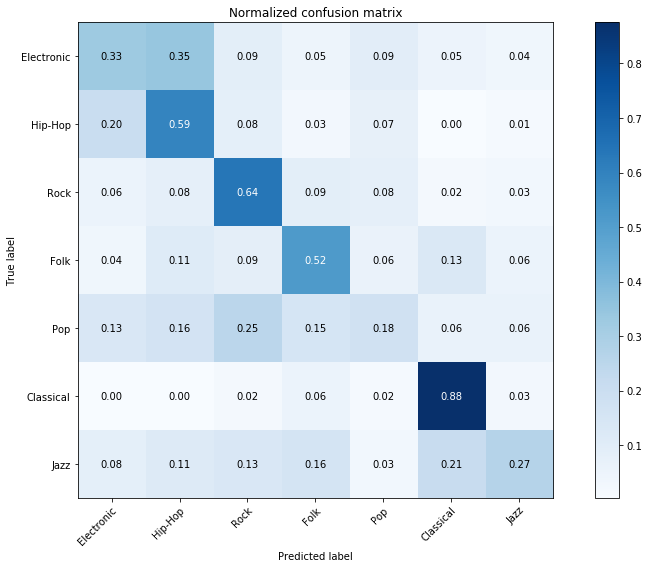

In [16]:
def feature_selection(X_train, X_test, y_train, y_test):
    '''
    Runs a backward feature selection using a KNN classifier
    and returns measured performance for all features considered.
    '''
    X_mfccs_train, X_chromas_train, X_tempo_train, X_crest_train, X_dur_train = map(list, zip(*X_train))
    X_mfccs_test, X_chromas_test, X_tempo_test, X_crest_test, X_dur_test = map(list, zip(*X_test))
    
    X_knn_train, coefficients = normalize_features(X_train)
    X_knn_test, _ = normalize_features(X_test, coefficients)
    
    def predict(enabled_features):
        knn = neighbors.KNeighborsClassifier(n_neighbors=30, weights='distance', n_jobs=-1)
        knn.fit(transform_features_knn(np.copy(X_knn_train), enabled_features), y_train)
        return knn.predict(transform_features_knn(np.copy(X_knn_test), enabled_features))
    
    features, top_f1 = '111x1', 0.3903
    print(f'Running backward feature selection...\n{features} {top_f1}')
    while features.count('1') > 1:
        best_trial_f1 = 0
        
        for idx, feature in enumerate(features):
            if feature == '1':            
                trial_features = features[:idx] + '0' + features[idx + 1:]
                f1 = metrics.classification_report(y_test, predict(trial_features), output_dict=True)['weighted avg']['f1-score']
                print(trial_features, '%.4f' % f1)

                if f1 >= best_trial_f1:
                    best_trial_idx = idx
                    best_trial_f1 = f1
                    best_trial_features = trial_features
        
        if best_trial_f1 < top_f1:
            break
            
        top_f1 = best_trial_f1
        features = best_trial_features
        print('Setting', features, 'as new best.\n')
            
    print('Best overall:', features)
    compute_confusion_matrix(y_test, predict(features))
    
    
if RERUN_BASELINES:
    feature_selection(X_train, X_test, y_train, y_test)

From the backward feature selection it can be concluded that MFFCs work the best for music genre classification, while MFFCs + audio duration still shows comparable performance. Removing the chroma features increases classification performance significantly.

From the confusion matrix it can also be seen that especially Pop and Jazz music is often mistaken for other genres, while Electronic music perhaps surprisingly often gets misclassified as Hip-Hop. This is likely due to both Electronic music and Hip-Hop being rich in low-frequency content.

## DenseNet

To improve classification performance further, we choose to model the problem using a neural architecture. More specifically, we implement the deep convolutional network architecture *DenseNet* as first proposed by <a href="https://arxiv.org/abs/1608.06993">Huang 2016</a> for use on 2-dimensional features. As MFFCs appear to model the problem the best, we will focus on that feature alone.

#### Global parameters

In [17]:
BATCH_SIZE = 256
CUDA = torch.cuda.is_available() # Check if we have a GPU available

print('CUDA has been enabled.' if CUDA else 'CUDA has been disabled.')

CUDA has been enabled.


#### Count parameters
Before we go ahead and build the actual networks, let's first define a simple function that takes a network and returns its number of parameters. This is useful for comparing different architectures to each other.

In [18]:
def num_params(net, verbose = True):
    count = sum(p.numel() for p in net.parameters())
    if verbose:
        print(f'Model parameters: {count}')
    return count

#### Data partitioning

For better GPU utilization, we group samples in mini-batches.

In [37]:
def convert_to_batches(data, is_y = False):
    '''
    Converts a list of numpy arrays to a list of
    batched numpy arrays of size BATCH_SIZE.
    '''
    batches, i = [], 0

    while i < len(data)-BATCH_SIZE:
        arr = data[i:i+BATCH_SIZE] if is_y is False else data[i:i+BATCH_SIZE]
        var = Variable(torch.from_numpy(np.array(arr)).float())
        batches.append(var)
        i += BATCH_SIZE
        
    return batches

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.1)

#X_train, coefficients = normalize_features(X_train)
#X_val, _ = normalize_features(X_val, coefficients)
#X_test, _ = normalize_features(X_test, coefficients)

X_train, _, __, ___, ____ = map(list, zip(*X_train))
X_val, _, __, ___, ____ = map(list, zip(*X_val))
X_test, _, __, ___, ____ = map(list, zip(*X_test))

X_train, X_val, X_test = convert_to_batches(X_train), convert_to_batches(X_val), convert_to_batches(X_test)
y_train, y_val, y_test = convert_to_batches(y_train, is_y=True), convert_to_batches(y_val, is_y=True), convert_to_batches(y_test, is_y=True)

print(f'Generated ({len(y_train)}, {len(y_val)}, {len(y_test)}) batches for training, validation and test.')

Generated (201, 22, 24) batches for training, validation and test.


#### Train

In [53]:
def accuracy(out, y):
    '''
    Calculate accuracy of model where
    out.shape = (batches, classes) and y.shape = (batches)
    '''
    out = torch.max(out, 1)[1].float()
    eq = torch.eq(out, y.float()).float()
    return torch.mean(eq)


def train_net(net, epochs=50, lr=1e-3, class_weights=None, verbose=True):
    
    # Transform class weights to Tensor
    weight = torch.Tensor(class_weights) if class_weights is not None else None
    
    # Move network to GPU if available
    if CUDA: net.cuda()
    if CUDA and weight is not None: weight = weight.cuda()
    
    criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=lr/100)
    losses, accs, val_losses, val_accs = [], [], [], []
    
    num_params(net)
    
    if verbose:
        start_time = time.time()
    
    def plot(losses, accs, val_losses, val_accs):
        '''
        Continously plots the training/validation loss and accuracy
        of the model being trained. This functions is only called if
        verbose is True for the training session.
        '''
        e = [i for i in range(len(losses))]
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(e, losses, label='Loss (Training)')
        
        plt.plot(e, val_losses, label='Loss (Validation)')
            
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(e, accs, label='Accuracy (Training)')
        
        plt.plot(e, val_accs, label='Accuracy (Validation)')
            
        plt.legend()
        plt.show()
        clear_output(wait=True)
    
    def run(net, X, y, optimize = False):
        '''
        This function constitutes a single epoch.
        If optimize is True, the associated optimizer will backpropagate
        and adjust network weights.
        Returns the average sample loss and accuracy for that epoch.
        '''
        epoch_loss, epoch_acc = 0, []
        
        if len(X) == 0 or len(y) == 0:
            raise ParameterError('Something went wrong. Invalid input!')
        
        # Helper function responsible for running a batch
        def run_batch(X, y, epoch_loss, epoch_acc):

            y = y.long()

            if CUDA:
                X = X.cuda()
                y = y.cuda()

            out = net(X)

            # Compute loss and accuracy for batch
            batch_loss = criterion(out, y)
            batch_acc = accuracy(out, y)  

            # If training session, initiate backpropagation and optimization
            if optimize == True:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            if CUDA:
                batch_acc = batch_acc.cpu()
                batch_loss = batch_loss.cpu()

            # Accumulate loss and accuracy for epoch metrics
            epoch_loss += batch_loss.data.numpy() / float(BATCH_SIZE)
            epoch_acc.append(batch_acc.data.numpy())

            return epoch_loss, epoch_acc

        # For each batch
        for i,x in enumerate(X):
            temp_loss, temp_acc = run_batch(x, y[i], epoch_loss, epoch_acc)
            epoch_loss += temp_loss / float(len(X))
            epoch_acc.append(np.mean(temp_acc))

        return epoch_loss, np.mean(epoch_acc)
    
    
    # Iterate over training epochs
    for epoch in range(epochs):
        
        net.train()
        loss, acc = run(net, X_train, y_train, optimize=True)
        losses.append(loss)
        accs.append(acc)
        
        net.eval()
        val_loss, val_acc = run(net, X_test, y_test)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Optionally plot performance metrics continously
        if verbose:
            
            # Print measured wall-time of first epoch
            if epoch == 0:
                dur = str(int((time.time() - start_time)/60))
                print(f'\nEpoch wall-time: {dur} min')
                
            plot(losses, accs, val_losses, val_accs)
            
    return net

#### Test

In [30]:
def evaluate_net(net):
    '''
    Evaluates a neural network using data defined
    by the X_test and y_test arrays. In order to
    evaluate the network, data dimensions obviously
    need to match the input size of the network.
    '''
    y_pred, y_true = [], []

    for idx, X in enumerate(X_test):

        y = y_test[idx]
        out = torch.argmax(net(X.cuda()), dim=1).cpu().data.numpy()

        y_pred.append(out)
        y_true.append(y.data.numpy().astype(int))

    y_pred = np.array(y_pred).flatten()
    y_true = np.array(y_true).flatten()

    compute_metrics(y_true, y_pred)

#### Network parameters

In [49]:
NUM_CHANNELS = 64, 96
NUM_LAYERS = 8
KERNEL_SIZE = 3
MAXPOOL_SIZE = 2
MAXPOOL_STRIDE = 2

#### Network implementation

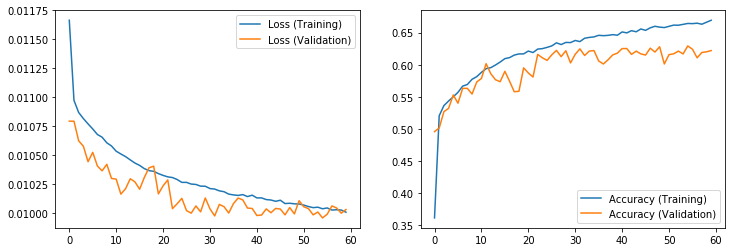

In [60]:
class DenseSingle(nn.Module):

    def __init__(self, input_size, output_size, dropout, dilation, padding, kernel_size, stride):
        super(DenseSingle, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=kernel_size, padding=padding, 
                      stride=stride, dilation=dilation, bias=False),
            nn.BatchNorm2d(output_size),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        out = self.layer(x)
        return torch.cat([x, out], 1)


class DenseBlock(nn.Module):
    
    def __init__(self, input_size, n_layers, growth_rate, dropout, dilation, padding, kernel_size, stride):
        super(DenseBlock, self).__init__()
        
        layers = []
        for i in range(n_layers):
            layers.append(DenseSingle(input_size + i * growth_rate, growth_rate, 
                                      dropout, dilation, padding, kernel_size, stride))
        
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):        
        return self.block(x)

    
class TransitionBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(TransitionBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        dropout = 0.4

        self.cnn_in = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=NUM_CHANNELS[0], kernel_size=6, stride=1, padding=0, 
                      dilation=4, bias=False),
            nn.BatchNorm2d(NUM_CHANNELS[0]),
            nn.MaxPool2d(kernel_size=MAXPOOL_SIZE, stride=MAXPOOL_STRIDE, padding=0),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )

        self.dense1 = DenseBlock(input_size=NUM_CHANNELS[0], n_layers=NUM_LAYERS, growth_rate=4, kernel_size=KERNEL_SIZE,
                                 dilation=1, padding=1, stride=1, dropout=dropout)

        self.trans1 = TransitionBlock(input_size=NUM_CHANNELS[1], output_size=NUM_CHANNELS[0], dropout=dropout)

        self.dense2 = DenseBlock(input_size=NUM_CHANNELS[0], n_layers=NUM_LAYERS, growth_rate=4, kernel_size=KERNEL_SIZE,
                                 dilation=1, padding=1, stride=1, dropout=dropout)

        self.cnn_out = nn.Sequential(
            nn.Conv2d(in_channels=NUM_CHANNELS[1], out_channels=NUM_CHANNELS[1], kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(NUM_CHANNELS[1]),
            nn.MaxPool2d(kernel_size=MAXPOOL_SIZE, stride=MAXPOOL_STRIDE, padding=0),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout)
        )

        self.out = nn.Linear(1248, NUM_CLASSES, bias=False)

            
    def forward(self, x):
        x = x.reshape((BATCH_SIZE, 1, NUM_FRAMES, MFCC_COEFFICIENTS))
        x = self.cnn_in(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.cnn_out(x)
        
        x = x.view(BATCH_SIZE, -1)
        return F.softmax(self.out(x), dim=1)

set_seed()
net = train_net(DenseNet(), epochs=60, lr=5e-4)

In [61]:
evaluate_net(net)

Accuracy: 61%

              precision    recall  f1-score   support

           0       0.67      0.57      0.61      1065
           1       0.63      0.85      0.72       800
           2       0.67      0.67      0.67       985
           3       0.55      0.66      0.60      1070
           4       0.42      0.19      0.26       810
           5       0.82      0.79      0.81       960
           6       0.34      0.46      0.39       454

    accuracy                           0.61      6144
   macro avg       0.59      0.60      0.58      6144
weighted avg       0.61      0.61      0.60      6144



Based on these experiments, it can be concluded that a DenseNet does in fact increase classification performance significantly as compared to KNN ($F_{1}$-score of 0.60 as opposed to 0.49). It is plausible that with more data and further fine-tuning, the network can achieve even better results, closing in on human-level performance.